In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

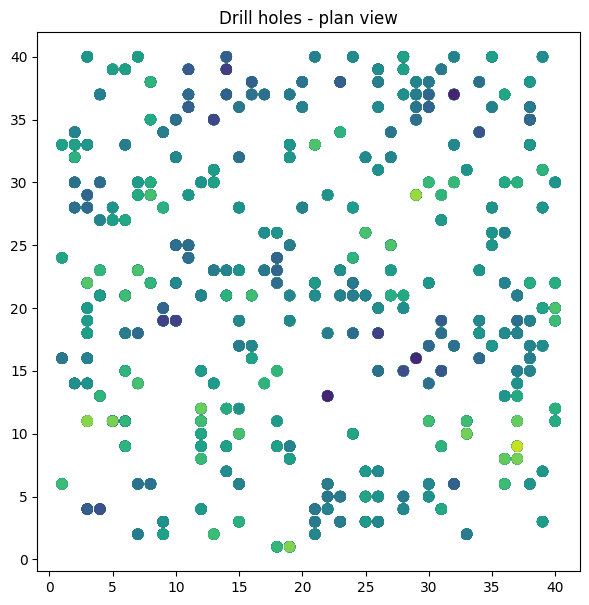

In [5]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 300

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])

fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### Creating a One Head Transformer

#### Create Training Dataset

In [6]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

In [10]:
class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=50)
val_loader = data.DataLoader(val, batch_size=50)
real_loader = data.DataLoader(real)

In [ ]:
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, int(hidden_size/2))
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(hidden_size/2), hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        # self.fc4 = nn.Linear(2*hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        return out
